In [1]:
import numpy as np
import sys
import json
import os
import utils
from scipy.special import softmax as softmax
from statistics import median
import matplotlib.pyplot as plt

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=1000)

In [2]:
#MANUAL INPUT + DEFAULT INPUTS
coarse=0           #coarse = 0 ; non-coarse = 1
dth=5             #threshold for data [Available:5,12,15]
M=3                #memory states [Available:1,2,3,4]
A=4                #action size 4 -> [up,left,right,up]


max_obs = 10       # distinct observations for rewards
O = 2              # distinct observations for actions [0, 1, 2, .., O-1]

symmetry=1
replica=0          #replica to avoid overwrite 

#Dimension of grid: Lx by Ly
Lx = 92            
Ly = 131

#Location of source (Lx0,Ly0)
Lx0 = 45.5
Ly0 = 91

if coarse == 1:    #change size and center for coarse set-up
    Lx=Lx-1
    Lx0=Lx0-45.5
    
lr=0.01            #learning rate
find_range=1.1     #radius from source location to be considered as found target
gamma=0.99975      #discount rate
V=100              #wind velocity for model plume


#combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., uM0, uM1, ..., dM0, dM1, ...
a_size = A * M
L = Lx*Ly

# cost move!
cost_move = 1-gamma
reward_find=0.0

# probability of track
beta = 1
sigma = 4

In [7]:
#To use an input file, change input_file=1. The default inputs are from the previous cell.
input_file=1

if input_file==1:    
    params = json.load(open('input.dat'))   ##change the file name
    coarse=params['coarse']   
    p_th=params['thresh']
    M = params["M"]         # size of memory m = {0,1}
    A = params["A"]         # action available in list: {left, right, up, down} 


    O = params["O"]         # distinct observations for actions [0, 1, 2, .., O-1]
    max_obs = params["max_obs"]  # distinct observations for rewards

    symmetry=params['symmetry']
    replica = params["replica"]


    Lx = params["Lx"]
    Ly = params["Ly"]
    Lx0 = (Lx/2)-0.5
    Ly0 = params["Ly0"]

    if coarse==1 and (Lx % 2) == 0:
        sys.exit('Error in value for Lx. In COARSE set-up, Lx should be an odd number')

    # Tolerance override
    if ("tol_eta" in params.keys()):
        tol_eta = params["tol_eta"]
    if ("tol_Q" in params.keys()):
        tol_Q = params["tol_Q"]
    if ("lr_th" in params.keys()):
        lr_th = params["lr_th"]
    if ("tol_conv" in params.keys()):
        tol_conv = params["tol_conv"]

    find_range = params["find_range"]
    gamma = params["gamma"]
    V = 100
    if ("V" in params.keys()):
        V = params["V"]

    # combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., sM0, sM1, ...
    a_size = A * M
    L = Lx*Ly

    # cost move
    cost_move = 1-gamma
    if ("cost_move" in params.keys()):
        beta = params["cost_move"]
    reward_find = params["reward_find"]

    beta = 5
    if ("beta" in params.keys()):
        beta = params["beta"]

    #Maxtime in optimization
    Ntot = params["Ntot"]
    #Printing time interval
    Nprint = params["Nprint"]
    

In [8]:
name_folder = 'outputs/ExpPlume_A{}M{}b{}g{}FR{}LR{}sym{}th{}rep{}LX{}LY{}co{}'.format(A,M,beta,gamma,find_range,lr_th,symmetry,dth,replica,Lx,Ly,coarse)
os.makedirs(name_folder, exist_ok=True)
#os.system("cp {} {}".format('./'+sys.argv[1], './'+name_folder))
f = open(name_folder+"/values.dat", "a")

#load plume data (already pre-processed)
data=np.loadtxt('data/exp_plume_symmetric_threshold{}.dat'.format(dth))
if coarse == 1:
    data=np.loadtxt('data/exp_plume_symmetric_coarse_threshold{}.dat'.format(dth))
data=np.array(data)

In [9]:
#LOADING SAVED POLICY
sub=0
new=0
#new=0 means the saved optimal policy we provided
#new=1 means the policy you saved as a result
#sub= 0 : best, 1: second best 
if new==0:
#load optimized policy
    name_folder='saved_policies/A{}M{}TH{}sub{}co{}'.format(A,M,dth,sub,coarse)
    th = np.loadtxt(name_folder + '/file_theta.out')
    th = th.reshape(O, M, a_size)
    Q = np.loadtxt(name_folder + '/file_Q.out')
    eta = np.loadtxt(name_folder + '/file_eta.out')
elif new==1:
#load your policy
#insert after output/ inside the '' the name of the folder 
    name_folder='output/'
    th = np.loadtxt(name_folder + '/file_theta.out')
    th = th.reshape(O, M, a_size)
    Q = np.loadtxt(name_folder + '/file_Q.out')
    eta = np.loadtxt(name_folder + '/file_eta.out')

In [10]:
#INITIALIZATIONS
PObs_lim, RR, PObs = utils.create_PObs_RR(Lx, Ly, Lx0, Ly0, find_range, cost_move, reward_find, M, sigma, max_obs, O, A, V, data)
PObs_lim = np.abs(PObs_lim)

#distribution relative to the PObs_lim
rho0 = np.zeros(M*Lx*Ly)
rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))


print('Lx :{}, Ly :{}'.format(Lx, Ly))
print('Lx0:{}, Ly0:{}'.format(Lx0, Ly0))
print('M:{}, th:{}, replica:{}'.format(M, dth,replica))
print('tol_conv:{}, tolQ:{}, toleta:{}, learn_rate:{}'.format(tol_conv,tol_Q,tol_eta,lr_th))
# ++++++++++++++++++
pi = softmax(th, axis=2)
print('the average value of the policy is:')
print(utils.get_value(Q, pi, PObs_lim, L, rho0))

Lx :92, Ly :131
Lx0:45.5, Ly0:91
M:3, th:5, replica:3
tol_conv:1e-06, tolQ:1e-08, toleta:1e-08, learn_rate:0.01
the average value of the policy is:
-0.1067866834225154


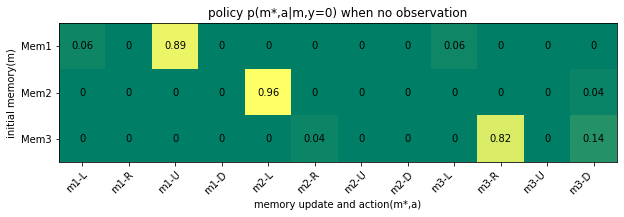

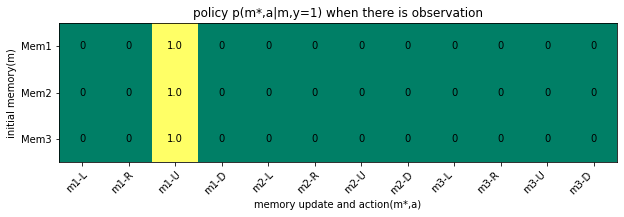

In [13]:
#POLICY ILLUSTRATION
# for y=0
p0=pi.reshape(O,M,M,A)[0].reshape(M,M*A)
actions = ["m1-L", "m1-R", "m1-U", "m1-D","m2-L", "m2-R", "m2-U", "m2-D","m3-L", 
           "m3-R", "m3-U", "m3-D","m4-L", "m4-R", "m4-U", "m4-D","m5-L", "m5-R", "m5-U", "m5-D"]
memory = ["Mem1", "Mem2", "Mem3",
           "Mem4", "Mem5"]

fig, ax = plt.subplots()
im = ax.imshow(p0,cmap='summer')
# Rotate the tick labels and set their alignment.

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(actions[:M*A])), labels=actions[:M*A])
ax.set_yticks(np.arange(len(memory[:M])), labels=memory[:M])

p00=np.round(p0,2)
for i in range(len(memory[:M])):
    for j in range(len(actions[:M*A])):
        if p00[i,j]==0.0:
            text = ax.text(j, i, 0,
                       ha="center", va="center", color="black") 
        else:
            text = ax.text(j, i, p00[i, j],
                       ha="center", va="center", color="black")
            
plt.title('policy p(m*,a|m,y=0) when no observation')
plt.ylabel('initial memory(m)',fontsize=10)
plt.xlabel('memory update and action(m*,a)',fontsize=10)
fig.set_size_inches(10, 6)
#plt.savefig(name_folder+'/policy_y0.png')


#for y=1
p1=pi.reshape(O,M,M,A)[1].reshape(M,M*A)
actions = ["m1-L", "m1-R", "m1-U", "m1-D","m2-L", "m2-R", "m2-U", "m2-D","m3-L", 
           "m3-R", "m3-U", "m3-D","m4-L", "m4-R", "m4-U", "m4-D","m5-L", "m5-R", "m5-U", "m5-D"]
memory = ["Mem1", "Mem2", "Mem3",
           "Mem4", "Mem5"]

fig, ax = plt.subplots()
im = ax.imshow(p1,cmap='summer')
# Rotate the tick labels and set their alignment.

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(actions[:M*A])), labels=actions[:M*A])
ax.set_yticks(np.arange(len(memory[:M])), labels=memory[:M])

p11=np.round(p1,2)
for i in range(len(memory[:M])):
    for j in range(len(actions[:M*A])):
        if p11[i,j]==0.0:
            text = ax.text(j, i, '0',
                       ha="center", va="center", color="black") 
        else:
            text = ax.text(j, i, p11[i, j],
                       ha="center", va="center", color="black")
        
plt.title('policy p(m*,a|m,y=1) when there is observation')
plt.ylabel('initial memory(m)',fontsize=10)
plt.xlabel('memory update and action(m*,a)',fontsize=10)
fig.set_size_inches(10, 6)
#plt.savefig(name_folder+'/policy_y1.png')

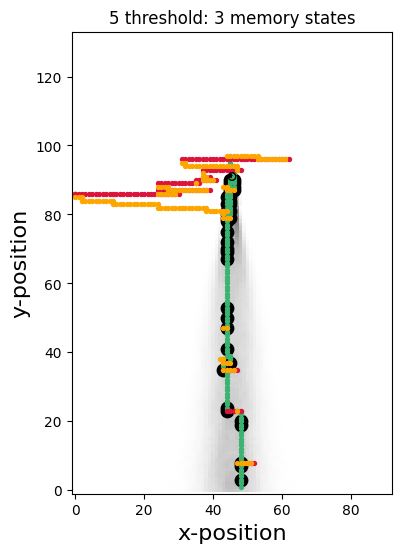

In [29]:
#TRAJECTORY sample
trj, ret, _ = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, gamma, PObs_lim, rho0, A)

scatter_x = trj[1:,1]
scatter_y = trj[1:,2]
group = trj[1:,3]
cdict = {2: 'orange', 0: 'mediumseagreen', 1: 'crimson', 3:'blue'}

fig, ax = plt.subplots()

ix = np.where(trj[1:,4] > 0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = 'black', s = 80)
ix = np.where(group == 0.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[0], label = 'Memory 0', s = 8)
ix = np.where(group == 1.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[1], label = 'Memory 1', s = 8)
ix = np.where(group == 2.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[2], label = 'Memory 2', s = 8)
ix = np.where(group == 3.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[3], label = 'Memory 3', s = 8)
#ax.legend()
ax.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:],cmap='Greys')
fig.set_size_inches(10, 6)
crange=plt.Circle((Lx0,Ly0),find_range,fill=False)
ax.set_aspect(1)

ax.add_artist(crange)
plt.title('{} threshold: {} memory states'.format(dth, M))
plt.xlim((-1,92))
plt.ylim((-1,133))
plt.xlabel('x-position',fontsize=16)
plt.ylabel('y-position',fontsize=16)
plt.show()

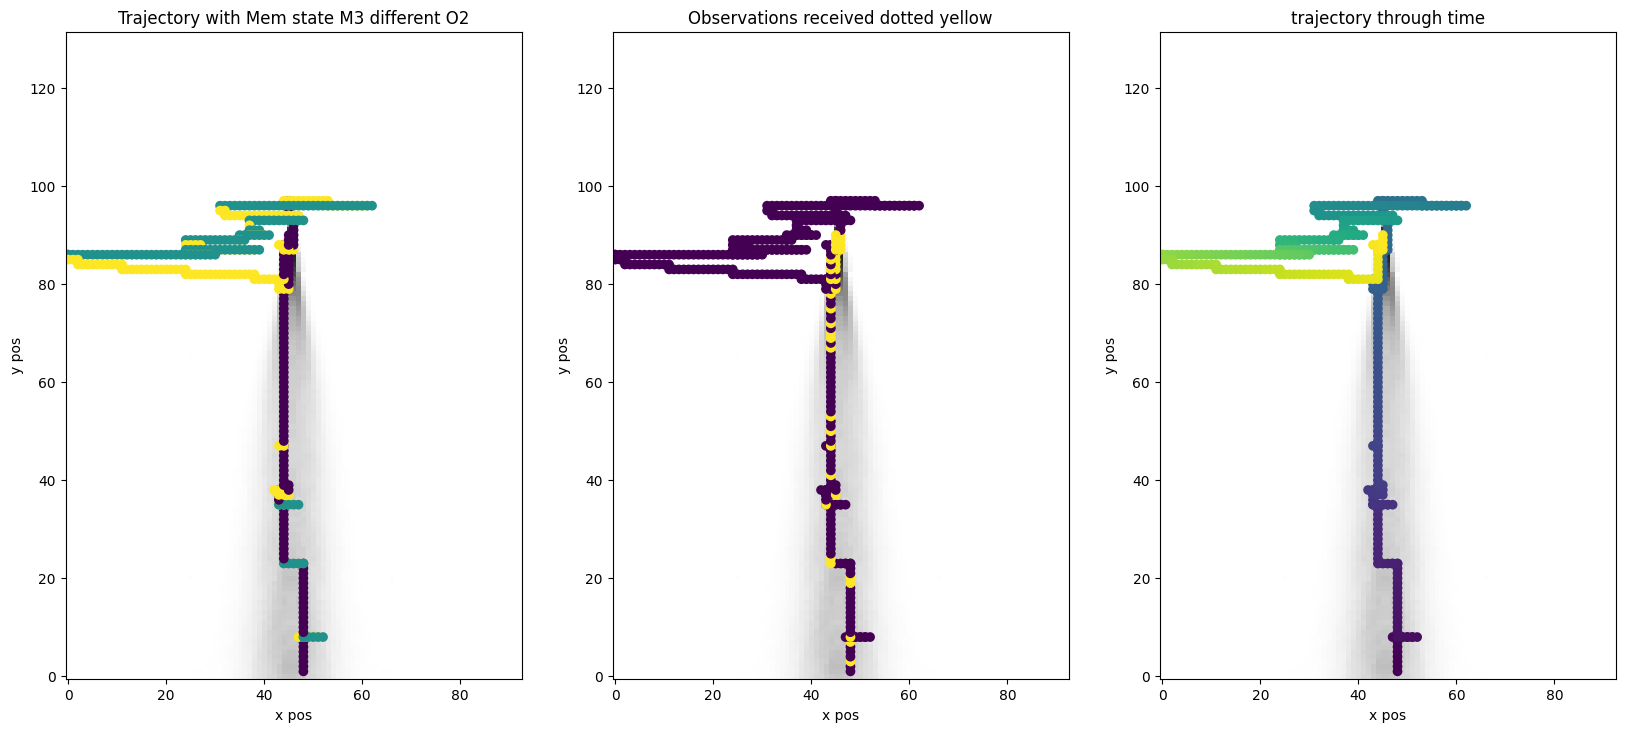

In [30]:
#PLOTTING TRAJECTORIES
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

plt.style.use('seaborn-v0_8')
ax1.set_xlim([-0.5, Lx+0.5])
ax1.set_ylim([-0.5, Ly+0.5])
ax2.set_xlim([-0.5, Lx+0.5])
ax2.set_ylim([-0.5, Ly+0.5])
ax3.set_xlim([-0.5, Lx+0.5])
ax3.set_ylim([-0.5, Ly+0.5])


ax1.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:])
ax2.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:])
ax3.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:])


plt.style.use('default')

plt.rcParams["figure.figsize"] = (20,11)

ax1.scatter(trj[1:,1], trj[1:,2], c=trj[1:,3])
ax1.set_aspect('equal')
ax1.set_title('Trajectory with Mem state M{} different O{}'.format(M, O))
ax1.set_xlabel('x pos')
ax1.set_ylabel('y pos')

#plt.clabel('Memory state')

#plt.plot(PObs[1][:L])

ax2.set_aspect('equal')
ax2.set_title('Observations received dotted yellow')
ax2.scatter(trj[1:,1], trj[1:,2], c=trj[1:,4])

ax2.set_xlabel('x pos')
ax2.set_ylabel('y pos')
#plt.clabel('Memory state')

ax3.set_aspect('equal')
ax3.set_title('trajectory through time')
ax3.scatter(trj[1:,1], trj[1:,2], c=np.arange(trj.shape[0]-1))

ax3.set_xlabel('x pos')
ax3.set_ylabel('y pos')

np.savetxt('trajectory.txt', trj[1:])
np.savetxt('PObs.txt', (1-PObs_lim[0,:]).reshape(M,Ly,Lx)[0,:])



In [27]:
#TIME DISTRIBUTIONS of search time 
#timedistributions

Nep = 1000    #number of trajectories to reproduce
av_ret = 0.
T = []
maxT = 10000  #maximum search time, not found before maxT would be counted as "failed search"

for i in range(Nep):
    _, ret, tau = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, maxT, PObs_lim, rho0, A)
    av_ret += ret
    T.append(tau)
print('Success Rate: {}%'.format(100*av_ret / Nep))


Success Rate: 1.0%


mean search time: 1440.438
median: 1049.0
std deviation: 1344.0030900842453


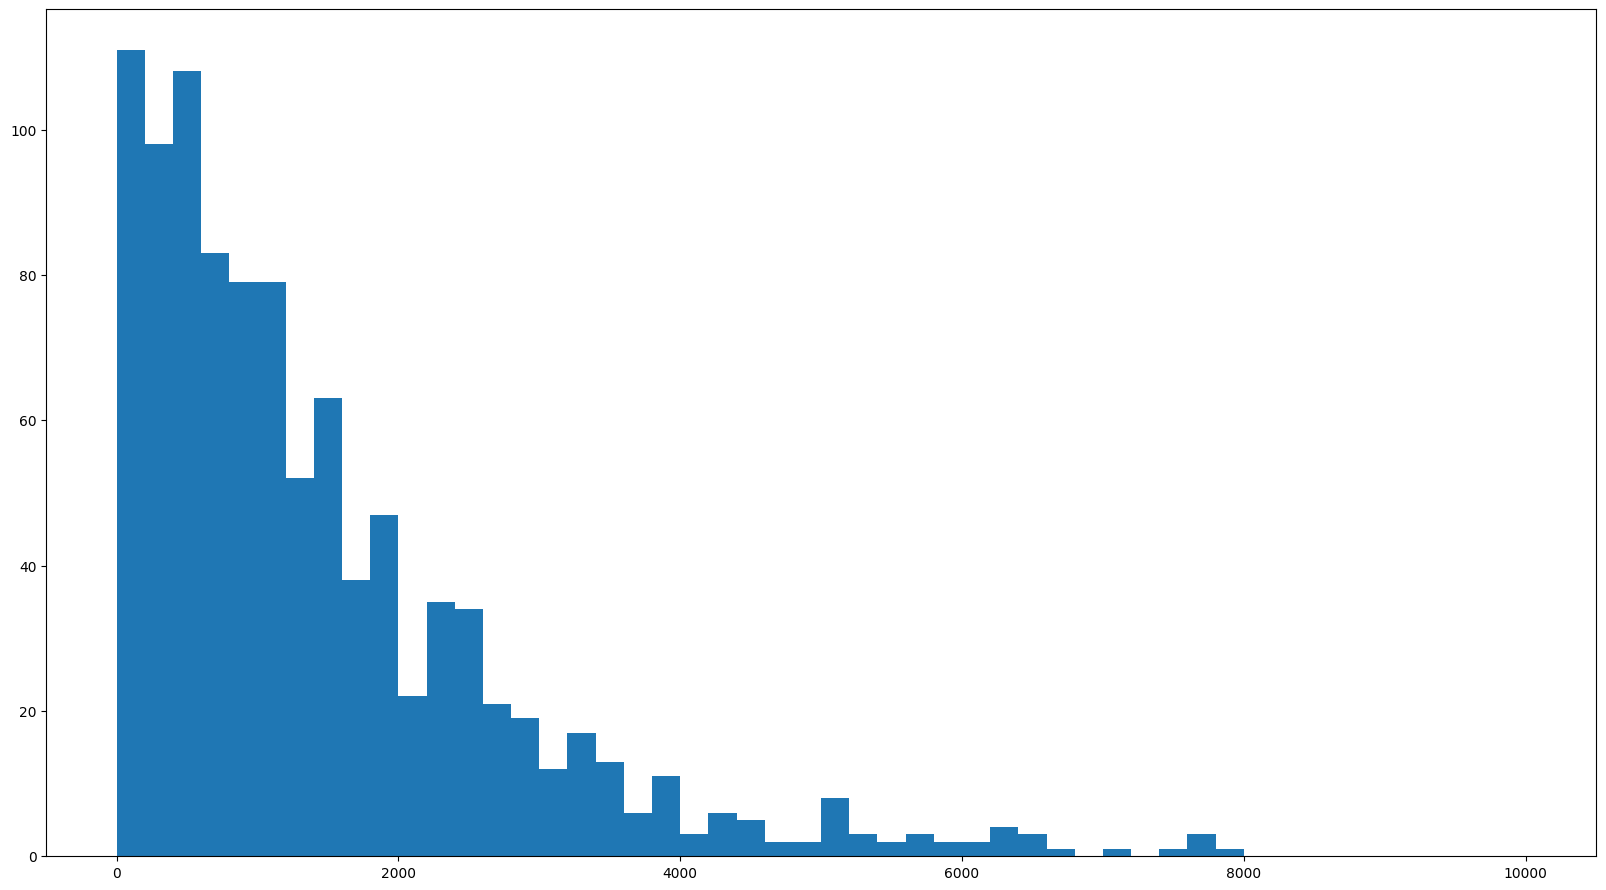

In [44]:
#TIME DISTRIBUTIONS of search time 
bins=50
plt.hist(T, bins,range=(0,maxT))
print('mean search time:',np.stack(T).mean())
print('median:',median(np.stack(T_success)))
print('std deviation:',np.stack(T).std())

In [31]:
#TIME DISTRIBUTIONS of search time -- only success
T=np.array(T)
T_success=T[T<maxT]
plt.hist(T_success, bins)
print('MIN search time:',np.mean(T_success))
print('mean search time:',np.stack(T_success).mean())
print('median:',median(np.stack(T_success)))
print('std deviation:',np.stack(T_success).std())

NameError: name 'T' is not defined

<AxesSubplot: ylabel='Density'>

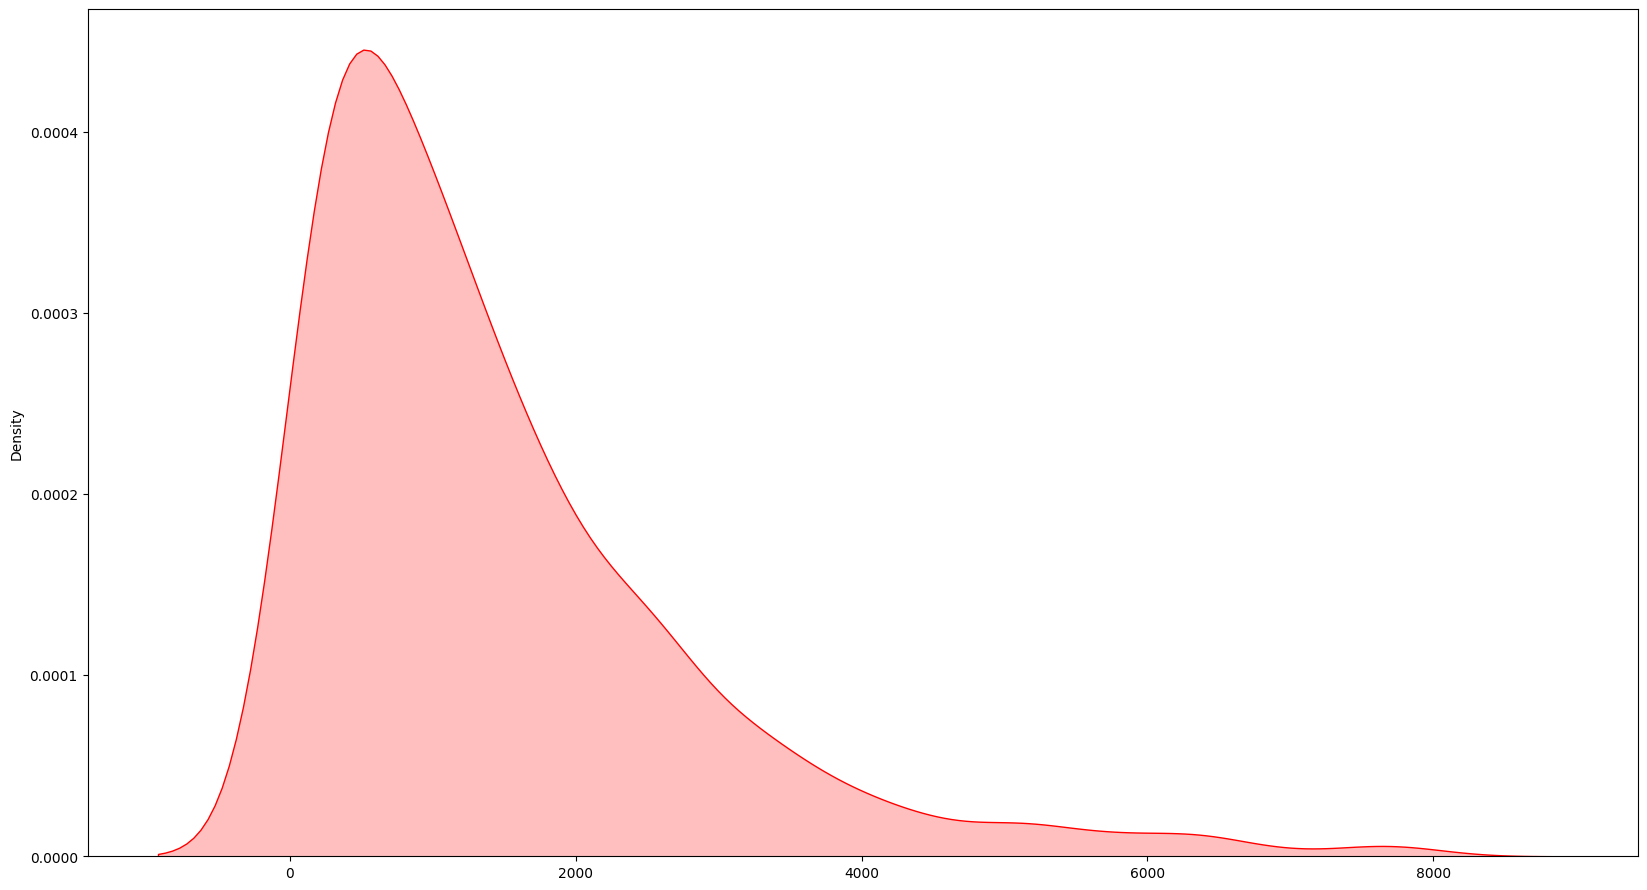

In [41]:
import seaborn as sns
sns.kdeplot(T_success,fill=True,color="red")